# Analyze Clusters dumped from Athena-Chain Tracking aglorithm

The purpose is to quantify the number of clusters / spacepoints in the Athena-Chain track candidates and to determine how much clusters one would lose if space points are used for tracking.

Input is obtained by running:
```bash
python /workspaces/visual_tracks/scripts/dumpITkTrackCandidates.py Dump_GNN4Itk_fullEvts_r14701_morebranch.root --num-evts 50 --no-csv
```

In [1]:
import matplotlib

matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xaxis.labellocation'] = "right"
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True

## Athena-Chain Track Candidates

In [14]:
filename = "/media/DataOcean/projects/tracking/integrateToAthena/run_main_clean/track_info_GNN4ITk.npz"

In [20]:
import numpy as np

# Load data
data = np.load(filename, allow_pickle=True)

In [4]:
[key for key in data.keys()]

['num_tracks',
 'num_clusters_per_track',
 'num_si_clusters_per_track',
 'num_pixel_clusters_per_track',
 'num_sp_per_track',
 'num_strip_sp_per_track',
 'num_non_ghost_sp_per_track',
 'num_non_ghost_strip_sp_per_track',
 'eta_per_track']

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
def get_profile(x, y, xbins, range):
    bin_means, bin_edges, binnumber = binned_statistic(
        x, y, statistic="mean", bins=xbins, range=range
    )
    bin_std, _, _ = binned_statistic(x, y, statistic="std", bins=xbins, range=range)

    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_width / 2
    return bin_centers, bin_means, bin_std


### Clusters

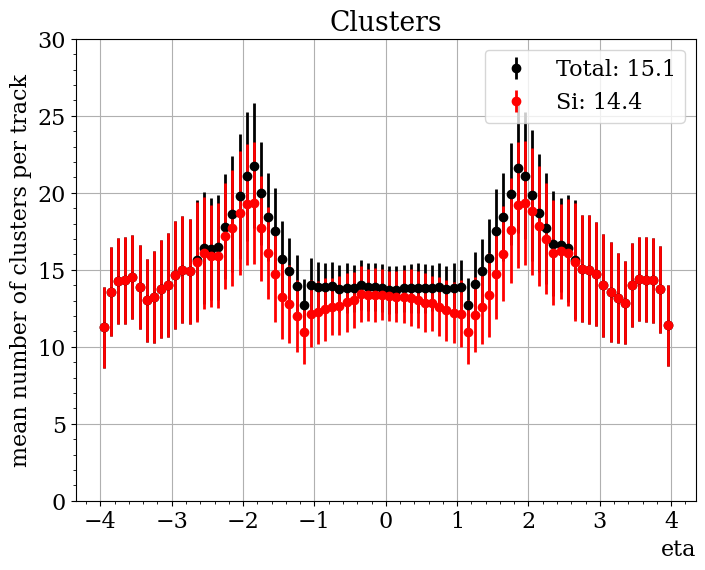

In [6]:

eta_config = {
    "xbins": 80,
    "range": [-4, 4]
}
bin_center, cluster_means, cluster_std = get_profile(data["eta_per_track"], data["num_clusters_per_track"], **eta_config)
_, sicluster_means, sicluster_std = get_profile(data["eta_per_track"], data["num_si_clusters_per_track"], **eta_config)


fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(bin_center, cluster_means, yerr=cluster_std, fmt="o", color="black", label="Total: {:.1f}".format(np.mean(data["num_clusters_per_track"])))
plt.errorbar(bin_center, sicluster_means, yerr=sicluster_std, fmt="o", color="red", label="Si: {:.1f}".format(np.mean(data["num_si_clusters_per_track"])))
plt.xlabel("eta")
plt.ylabel("mean number of clusters per track")
plt.ylim(0, 30)
plt.title("Clusters")
plt.legend()
plt.grid()
plt.show()

On average, (15.1 - 14.4) / 15.1 = 4.6% of the strip clusters do not have a corresponding space point. Therefore, these clusters will be losted in the GNN-based tracking algorithm.

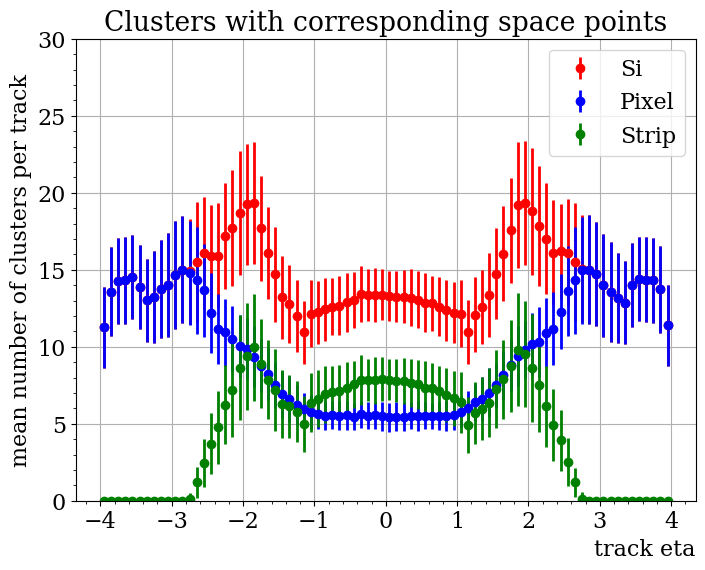

In [7]:
eta_config = {
    "xbins": 80,
    "range": [-4, 4]
}
bin_center, sicluster_means, sicluster_std = get_profile(data["eta_per_track"], data["num_si_clusters_per_track"], **eta_config)
_, pixel_means, pixel_std = get_profile(data["eta_per_track"], data["num_pixel_clusters_per_track"], **eta_config)
num_strip_clusters_per_track = data["num_si_clusters_per_track"] - data["num_pixel_clusters_per_track"]
_, strip_means, strip_std = get_profile(data["eta_per_track"], num_strip_clusters_per_track, **eta_config)

fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(bin_center, sicluster_means, yerr=sicluster_std, fmt="o", color="red", label="Si")
plt.errorbar(bin_center, pixel_means, yerr=pixel_std, fmt="o", color="blue", label="Pixel")
plt.errorbar(bin_center, strip_means, yerr=strip_std, fmt="o", color="green", label="Strip")
plt.xlabel("track eta")
plt.ylabel("mean number of clusters per track")
plt.ylim(0, 30)
plt.title("Clusters with corresponding space points")
plt.legend()
plt.grid()
plt.show()


### Space points

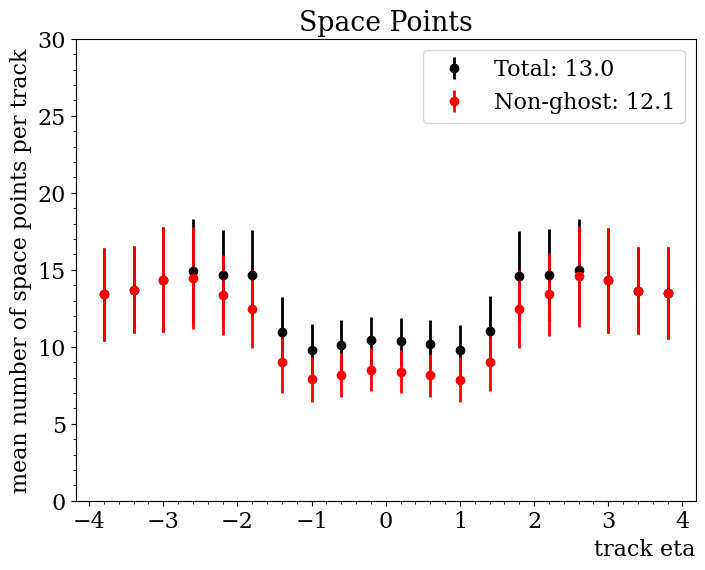

In [8]:
eta_config = {
    "xbins": 20,
    "range": [-4, 4]
}
bin_center, sp_means, sp_std = get_profile(data["eta_per_track"], data["num_sp_per_track"], **eta_config)
_, nonghost_sp_means, nonghost_sp_std = get_profile(data["eta_per_track"], data["num_non_ghost_sp_per_track"], **eta_config)

fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(bin_center, sp_means, yerr=sp_std, fmt="o", color="black", label="Total: {:.1f}".format(np.mean(data["num_sp_per_track"])))
plt.errorbar(bin_center, nonghost_sp_means, yerr=nonghost_sp_std, fmt="o", color="red", label="Non-ghost: {:.1f}".format(np.mean(data["num_non_ghost_sp_per_track"])))
plt.xlabel("track eta")
plt.ylabel("mean number of space points per track")
plt.title("Space Points")
plt.ylim(0, 30)
plt.legend()
plt.show()

* Total number of space points per track is the number of unique spacepoints in the track. 
* Non-ghost space point means the space point has two strip clusters in the track. 
* The difference between "total" and "non-ghost" is the number of strip space points that do not have two strip clusters in the track. On avereage, that is (13.0 - 12.1) / 13.0 = 6.9% of all space points.

If we add these ghost space points, the track candidate will inevitably include "outlier" clusters. If we remove these ghost space points, the track candidate will inevitably miss some clusters, meaning more holes.

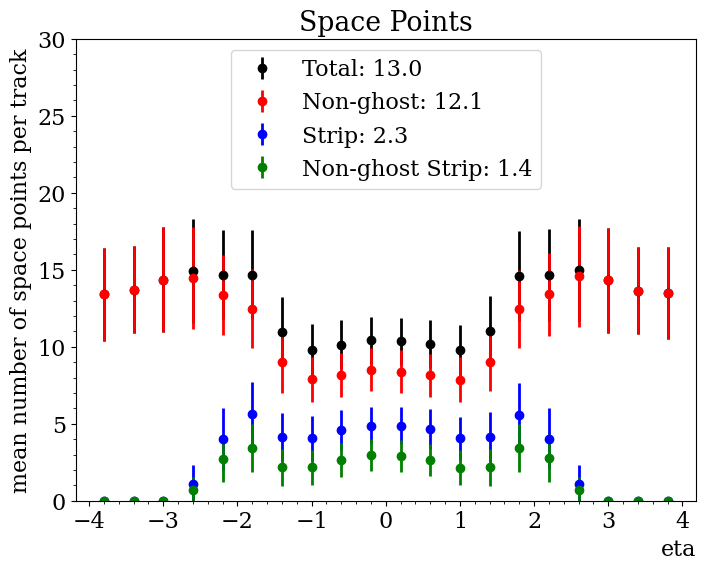

In [9]:
eta_config = {
    "xbins": 20,
    "range": [-4, 4]
}
bin_center, sp_means, sp_std = get_profile(data["eta_per_track"], data["num_sp_per_track"], **eta_config)
_, strip_means, strip_std = get_profile(data["eta_per_track"], data["num_strip_sp_per_track"], **eta_config)
_, nonghost_sp_means, nonghost_sp_std = get_profile(data["eta_per_track"], data["num_non_ghost_sp_per_track"], **eta_config)
_, nonghost_strip_means, nonghost_strip_std = get_profile(data["eta_per_track"], data["num_non_ghost_strip_sp_per_track"], **eta_config)

fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(bin_center, sp_means, yerr=sp_std, fmt="o", color="black", label="Total: {:.1f}".format(np.mean(data["num_sp_per_track"])))
plt.errorbar(bin_center, nonghost_sp_means, yerr=nonghost_sp_std, fmt="o", color="red", label="Non-ghost: {:.1f}".format(np.mean(data["num_non_ghost_sp_per_track"])))
plt.errorbar(bin_center, strip_means, yerr=strip_std, fmt="o", color="blue", label="Strip: {:.1f}".format(np.mean(data["num_strip_sp_per_track"])))
plt.errorbar(bin_center, nonghost_strip_means, yerr=nonghost_strip_std, fmt="o", color="green", label="Non-ghost Strip: {:.1f}".format(np.mean(data["num_non_ghost_strip_sp_per_track"])))
plt.xlabel("eta")
plt.ylabel("mean number of space points per track")
plt.title("Space Points")
plt.legend(loc="upper center")
plt.ylim(0, 30)
plt.show()

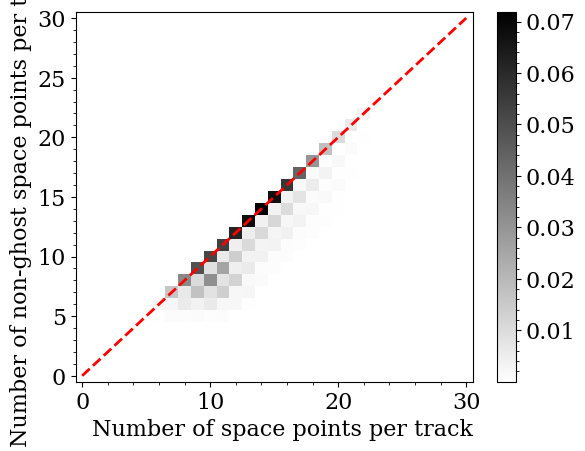

In [10]:
plt.hist2d(data["num_sp_per_track"], data["num_non_ghost_sp_per_track"], bins=(31, 31), range=[[-0.5, 30.5], [-0.5, 30.5]], cmap=plt.cm.binary, cmin=0.000001, density=True)
plt.colorbar()
plt.plot([0, 30], [0, 30], "r--")
plt.xlabel("Number of space points per track")
plt.ylabel("Number of non-ghost space points per track")
plt.show()

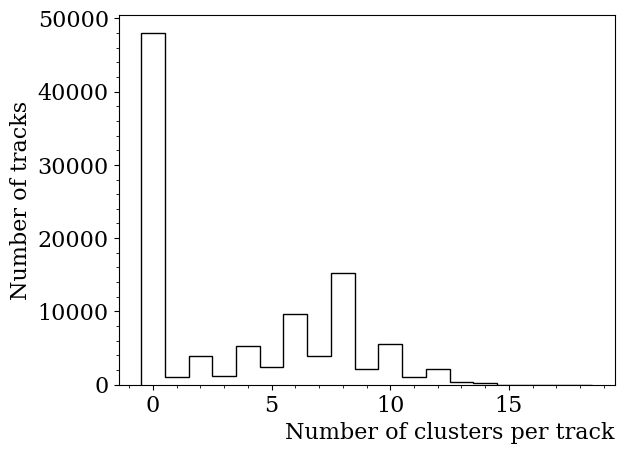

In [16]:
counts, _, _ = plt.hist(num_strip_clusters_per_track, bins=19, range=[-0.5, 18.5], histtype="step", color="black", label="Total")
plt.xlabel("Number of clusters per track")
plt.ylabel("Number of tracks")
plt.show()

In [12]:
frac_of_even_bins, frac_odd_bins = np.sum(counts[2::2]), np.sum(counts[1::2])
frac_of_even_bins, frac_odd_bins

(0.4109307782557685, 0.11949550254204144)